Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'2.0.0-beta1'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Train RNN model with CTC loss on the generated emnist-lines dataset

From Keras examples [image_ocr.py](https://github.com/keras-team/keras/blob/master/examples/image_ocr.py) and [Chengwei's post](https://www.dlology.com/blog/how-to-train-a-keras-model-to-recognize-variable-length-text/) helped me a lot in getting the ctc loss working correctly.

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
# To be able to write code as if this notebook was one level up in files tree structure.
sys.path.append('..')

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import ctc_ops
from tensorflow.python.ops import math_ops as tf_math_ops

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

import pandas as pd
from PIL import Image

In [4]:
from recognizer.datasets import Dataset
from recognizer.datasets import EmnistDataset
from recognizer.networks import lenet
from recognizer.networks import simple
from recognizer.networks import NetworkInput

Hyperparameters

In [5]:
batch_size = 128
epochs = 16
train_valid_length = 10000  # 124  # 10000

In [6]:
model_save_path = Path("../recognizer/weights/lines_ctc_loss.h5")

## Load characters mapping

In [7]:
import json

with open(Dataset.raw_data_path()/"emnist"/"emnist_essentials.json") as json_file:  
    mapping = json.load(json_file)["mapping"]
    mapping = {m[0]: m[1] for m in mapping}
    mapping[62] = ' '
    mapping[63] = '_'
    
mapping_reversed = {v: k for k, v in mapping.items()}

In [8]:
def labels_to_text(labels):
    return "".join([mapping[c] for c in labels])

## Build the new model

In [9]:
char_image_height = 28
char_image_width = 28
max_length = 34
num_classes = 64
image_height = char_image_height
image_width = char_image_width * max_length

input_shape = (image_height, image_width)
output_shape = (max_length, num_classes)

window_width: float = 16
window_stride: float = 8
    
num_windows = ((image_width - window_width) // window_stride) + 1
if num_windows < max_length:
    raise ValueError(f'Window width/stride need to generate >= {max_length} windows (currently {num_windows})')

In [10]:
def slide_window(image, window_width, window_stride):
    """
    Takes (image_height, image_width, 1) input,
    Returns (num_windows, image_height, window_width, 1) output, where
    num_windows is floor((image_width - window_width) / window_stride) + 1
    """
    patches = tf.image.extract_patches(image, 
                                             sizes=[1, 1, window_width, 1], 
                                             strides=[1, 1, window_stride, 1], 
                                             rates=[1, 1, 1, 1], 
                                             padding='VALID')
    patches = tf.transpose(patches, (0, 2, 1, 3))
    patches = tf.expand_dims(patches, -1)
    
    return patches

In [11]:
window_width = 12
window_stride = 5

image_input = layers.Input(shape=input_shape, name='image')
image_reshaped = layers.Reshape((image_height, image_width, 1))(image_input)

image_patches = layers.Lambda(
    slide_window,
    arguments={'window_width': window_width, 'window_stride': window_stride}
)(image_reshaped)

In [12]:
image_patches

<tf.Tensor 'lambda/Identity:0' shape=(None, 189, 28, 12, 1) dtype=float32>

### The model

In [13]:
# the actual loss calc occurs here despite it not being an internal Keras loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# For merging the windows and getting the predicted text in readable form
def decode_predict_ctc(outs, top_paths=1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
          beam_width = top_paths
  
    for out in outs:
        out = np.expand_dims(out, axis=0)
        paths = []
        for i in range(top_paths):
            lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                               greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
            text = labels_to_text(lables)
            paths.append(text)

        results.append(paths)
        
    return results

In [14]:
convnet_base = lenet(NetworkInput(input_shape=(image_height, window_width, 1), number_of_classes=num_classes))
convnet_base.layers

In [15]:
# Get rid of the last two layers (dropout and softmax)
convnet = KerasModel(inputs=convnet_base.inputs, outputs=convnet_base.layers[-2].output)
time_distributed_outputs = layers.TimeDistributed(convnet)(image_patches)

# Try a single lstm
rnn_outputs = layers.LSTM(128, return_sequences=True)(time_distributed_outputs)

# Try one GRU layer
# rnn_outputs = layers.GRU(256, return_sequences=True)(time_distributed_outputs)

# Try two layers of bidirectional GRUs
# rnn_outputs = layers.Bidirectional(layers.GRU(128, return_sequences=True))(time_distributed_outputs)
# rnn_outputs = layers.Bidirectional(layers.GRU(64, return_sequences=True))(rnn_outputs)

y_pred = layers.Dense(num_classes, activation='softmax', name='softmax_output')(rnn_outputs)
KerasModel(inputs=image_input, outputs=y_pred).summary()

# Add ctc specific ipnuts for the training model, the predication model will just need access to `image_input`
labels = layers.Input(name='the_labels', shape=[max_length], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = KerasModel(inputs=[image_input, labels, input_length, label_length], outputs=loss_out)

# # clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(optimizer=sgd, loss={'ctc': lambda y_true, y_pred: y_pred})

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 952)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 952, 1)        0         
_________________________________________________________________
lambda (Lambda)              (None, 189, 28, 12, 1)    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 128)          412160    
_________________________________________________________________
lstm (LSTM)                  (None, 189, 128)          131584    
_________________________________________________________________
softmax_output (Dense)       (None, 189, 64)           8256      
Total params: 552,000
Trainable params: 552,000
Non-trainable params: 0
_____________________________________________________

## Build the generators

In [16]:
df = pd.read_csv(Dataset.processed_data_path()/"emnist_lines"/"data.csv")

output_length = len(df)

In [17]:
df.head()

,image,sentence
0,0.png,Whats wrong at state _____________
1,1.png,The transducer itself moves the __
2,2.png,There is an ancient and venerable
3,3.png,They destroyed a trading house ___
4,4.png,Alec waited a moment on guard ___


Shuffle the data and reset their index

In [18]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image,sentence
0,20433.png,Lucy Upton was graduated from the
1,1603.png,If you cant think of a thing to __
2,1067.png,The number of people acting as ___
3,34622.png,_________________________________
4,1034.png,Far from being irrelevant to the _


In [19]:
# # For the sake of debugging let us test only one sentence
# df = df.iloc[[0] * len(df)]
# df

Split data into train and valid

In [20]:
df = df.iloc[:train_valid_length]

valid_length = int(len(df) * .2)

train_df = df.iloc[valid_length:]
valid_df = df.iloc[:valid_length]

len(train_df), valid_length

(8000, 2000)

## Train it

In [21]:
class LinesDataSequence(Sequence):
    
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size

    def __len__(self):
        return len(self.df) // batch_size

    def __getitem__(self, idx):
        """Return a single batch."""
        X_data = np.ones([self.batch_size, image_height, image_width])

        labels = np.ones([self.batch_size, max_length])
        input_length = np.zeros([self.batch_size, 1])
        label_length = np.zeros([self.batch_size, 1])
        
        for i in range(self.batch_size):
            index = i + idx
            row = self.df.iloc[index]
            
            image = Image.open(Dataset.processed_data_path()/"emnist_lines"/row['image'])
            image = np.array(image).astype(np.float32) / 255
            image = image.reshape(image_height, image_width)
            X_data[i, :, :] = image
            
            y = [mapping_reversed[char] for char in row['sentence']]
            y = to_categorical(y, num_classes).astype(np.int)
            labels[i, :] = np.argmax(y, axis=-1)
            
            # input_length refers to your sequence length and label_length refers to the ground truth label length
            # TODO :: Not sure what to do with this!
            input_length[i] = 189 - 2  # 64  # 34  # 189
            
            # Find all of the indices in the label that are not blank
            empty_at = np.where(y[:, -1] == 1)[0]
            # Length of the label is the pos of the first blank, or the max length
            if empty_at.shape[0] > 0:
                label_length[i] = empty_at[0]
            else:
                label_length[i] = y.shape[0]
            
        inputs = {
            'image': X_data,
            'the_labels': labels,
            'input_length': input_length,
            'label_length': label_length
        }
        outputs = {'ctc': np.zeros([self.batch_size])}  # dummy data for dummy loss function

        return (inputs, outputs)

In [22]:
train_sequence = LinesDataSequence(train_df, batch_size)
steps_per_epoch = len(train_df) // batch_size
validation_sequence = LinesDataSequence(valid_df, batch_size)
validation_steps = len(valid_df) // batch_size

#### Prepare the callbacks

In [23]:
# index = 0

# image = Image.open(Dataset.processed_data_path()/"emnist_lines"/df.iloc[index]['image'])
# image_numpy = np.array(image).astype(np.float32)

# sentence = df.iloc[index]['sentence']

# batch = np.expand_dims(image_numpy, axis=0)  # Create a fake batch of one image


# model_pred = KerasModel(inputs=image_input, outputs=y_pred)

# net_out_values = model_pred.predict(batch)
# text_pred = decode_predict_ctc(net_out_values, top_paths=1)
# sentence, text_pred

In [24]:
import editdistance


class ValidationDistanceCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        mean_distance = 0.
        
        model_pred = KerasModel(inputs=image_input, outputs=y_pred)

        # Calculate loss
        loss = model.evaluate_generator(
            validation_sequence,
            steps=validation_steps
        )
        
        # Get the predications
        net_out_values = model_pred.predict_generator(
            validation_sequence,
            steps=validation_steps
        )
        text_pred = decode_predict_ctc(net_out_values, top_paths=1)
        
        index = 0
        print_first = True
        for sequence, _ in validation_sequence:
            for labels in sequence['the_labels']:
                text = labels_to_text(labels)
                if print_first:
                    print(f"\nTrue: {text}, pred: {text_pred[index][0]}")
                    print_first = False
                mean_distance += editdistance.eval(text_pred[index][0], text)
                index += 1

        mean_distance /= index
        
        print(f"\nEvaluating: total {index}, loss {loss:.4f}, mean_distance {mean_distance:.4f}")

Check progress in TensorBoard by running `tensorboard --logdir=logs/lines_ctc_loss` in terminal

In [25]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_ctc_loss'),
    ValidationDistanceCallback()
]

#### Fit the model

In [26]:
history = model.fit_generator(
    train_sequence,
    steps_per_epoch=steps_per_epoch,
#     validation_data=validation_sequence,
#     validation_steps=validation_steps,
    epochs=epochs,
    callbacks=callbacks)
history.history.keys()

Epoch 1/16
61/62 [============================>.] - ETA: 1s - loss: 115.0228WARNING:tensorflow:From /home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:5537: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.

True: Lucy Upton was graduated from the , pred: [' ']

Evaluating: total 1920, loss 94.1429, mean_distance 33.0000
62/62 [==============================] - 96s 2s/step - loss: 114.6956
Epoch 2/16
61/62 [============================>.] - ETA: 0s - loss: 93.2407
True: Lucy Upton was graduated from the , pred: [' ']

Evaluating: total 1920, loss 93.7660, mean_distance 33.0000
62/62 [==============================] - 83s 1s/step - loss: 93.2580
Epoch 3/16
61/62 [============================>.] - ETA: 0s - loss: 92.6457
True: Lucy Upton was graduated from the

dict_keys(['loss'])

KeyError: 'val_loss'

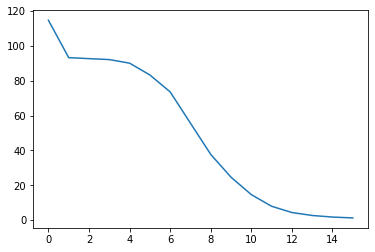

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Save the model

In [ ]:
model.save(model_save_path)

## Restore the model

In [ ]:
# model = keras.models.load_model(model_save_path)

# model.trainable = False
# model.compile(optimizer=sgd, loss={'ctc': lambda y_true, y_pred: y_pred})

# Load weights into the model instead

## Evaluate

In [ ]:
model_save_path

In [ ]:
model_pred = KerasModel(inputs=image_input, outputs=y_pred)
# model_pred.load_weights(str(model_save_path))
# model_pred.trainable = False
# model_pred.compile(optimizer=sgd, loss='categorical_crossentropy')

model_pred.summary()

In [ ]:
def predit_on_image(model, img, top_paths=1):
    batch = np.expand_dims(img, axis=0)  # Create a fake batch of one image
    net_out_value = model.predict(batch)
    top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
    
    return top_pred_texts

In [ ]:
index = 0

image = Image.open(Dataset.processed_data_path()/"emnist_lines"/df.iloc[index]['image'])
image_numpy = np.array(image).astype(np.float32) / 255

sentence = df.iloc[index]['sentence']
# y = [mapping_reversed[char] for char in sentence]
# y = to_categorical(y, num_classes).astype(np.int)
# test_batch_y = y.reshape((1,) + y.shape)

results = predit_on_image(model_pred, image_numpy, top_paths=3)
sentence, results

In [ ]:
image